In [8]:
# Skip the complex to real warnings and the LAL warnings
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import lal
from lal import MSUN_SI, MTSUN_SI, PC_SI
import lalsimulation as lalsim
from lalsimulation import IMRPhenomXAS, IMRPhenomXAS_NRTidalv3
MPC_SI = PC_SI * 1e6
print(lalsim.__version__)

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from jax.scipy.integrate import trapezoid
import numpy as np
import matplotlib.pyplot as plt

from ripplegw import ms_to_Mc_eta, lambdas_to_lambda_tildes
from ripplegw.waveforms.IMRPhenomXAS import gen_IMRPhenomXAS_hphc
from ripplegw.waveforms.IMRPhenomXAS_NRTidalv3 import gen_IMRPhenomXAS_NRTidalv3_hphc
from ripplegw.waveforms.IMRPhenomX_utils import PhenomX_amp_coeff_table
from ripplegw.waveforms import IMRPhenomXAS as ripple_XAS

6.2.0


In [4]:
# Choose the ET PSD just to have the wide frequency range
psd_freqs, *psd_arrs = np.loadtxt("psds/ET-D-psd.txt", unpack=True)
psd_arr = psd_arrs[0]

def get_freq_array(sampling_freqs, duration):
    # Build the frequency grid
    delta_t = 1 / sampling_freqs
    tlen = int(round(duration * sampling_freqs))
    freqs = jnp.fft.rfftfreq(tlen, delta_t)
    return freqs


def noise_weighted_inner_product(h1, h2, psd, frequencies):
    integrand = jnp.conj(h1) * h2 / psd
    return 4 * trapezoid(integrand, x=frequencies, axis=-1).real


def compute_match(h1, h2, psd, frequencies):
    h1_sq = noise_weighted_inner_product(h1, h1, psd, frequencies)
    h2_sq = noise_weighted_inner_product(h2, h2, psd, frequencies)
    h1_h2 = noise_weighted_inner_product(h1, h2, psd, frequencies)
    match = h1_h2 / jnp.sqrt(h1_sq * h2_sq)
    return match.real

In [82]:
duration = 16.0
fs = 4096.0
f_min = 5.0
f_max = fs / 2


def lal_XAS_h_plus(mass_1, mass_2, a_1, a_2, inclination, phase, Lambda_1, Lambda_2,
                     duration, f_min, f_max, reference_frequency):

    XAS_hp = lalsim.SimIMRPhenomXASGenerateFD(
        mass_1 * MSUN_SI,
        mass_2 * MSUN_SI,
        a_1, a_2, 
        1,  # m
        f_min, f_max, 
        1.0 / duration,
        0.0,
        reference_frequency, 
        None,
    )
    hpc_len = len(XAS_hp.data.data)

    frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
    zeros = jnp.zeros_like(frequencies, dtype=jnp.complex128)
    hp = zeros.at[:hpc_len].set(XAS_hp.data.data)

    return frequencies, hp

def ripple_XAS_waveform(mass_1, mass_2, a_1, a_2, inclination, phase, Lambda_1, Lambda_2,
                        duration, f_min, f_max, reference_frequency):

    frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
    frequency_mask = (frequencies >= f_min) & (frequencies <= f_max)

    ones = jnp.ones_like(mass_1)
    chirp_mass, symmetric_mass_ratio = ms_to_Mc_eta(jnp.array([mass_1, mass_2]))

    thetas = jnp.array([
        chirp_mass, symmetric_mass_ratio, a_1, a_2, 
        ones/MPC_SI, ones*0., phase, inclination
    ])

    zeros = jnp.zeros_like(frequencies, dtype=jnp.complex128)

    @jax.jit
    def waveform(theta):
        hpc = gen_IMRPhenomXAS_hphc(
            frequencies[frequency_mask],
            theta, reference_frequency
        )
        hp = zeros.at[frequency_mask].set(hpc[0])
        hc = zeros.at[frequency_mask].set(hpc[1])
        return hp, hc

    if thetas[0].size > 1:
        ripple_hpc = jax.vmap(waveform)(thetas.T)
    else:
        ripple_hpc = waveform(thetas)

    return frequencies, *ripple_hpc


def ripple_XAS_amplitude(mass_1, mass_2, a_1, a_2, inclination, phase, Lambda_1, Lambda_2,
                         duration, f_min, f_max, reference_frequency):

    frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
    frequency_mask = (frequencies >= f_min) & (frequencies <= f_max)

    thetas = jnp.array([
        mass_1, mass_2, a_1, a_2, 
    ])
    zeros = jnp.zeros_like(frequencies, dtype=jnp.float64)

    @jax.jit
    def waveform(theta):
        amps = ripple_XAS.Amp(
            frequencies[frequency_mask],
            theta, PhenomX_amp_coeff_table, D=1/MPC_SI
        )
        return zeros.at[frequency_mask].set(amps)

    if thetas[0].size > 1:
        ripple_hpc = jax.vmap(waveform)(thetas.T)
    else:
        ripple_hpc = waveform(thetas)

    return frequencies, ripple_hpc

In [83]:
seed = 10
Nsamples = 100

rand_arr = jax.random.uniform(jax.random.PRNGKey(seed), 
                              (8, Nsamples), dtype=jnp.float64)
total_mass = rand_arr[0] * 5.5 + 0.5
mass_ratio = rand_arr[1] * 0.95 + 0.05
mass_1 = total_mass / (1 + mass_ratio)
mass_2 = total_mass - mass_1
chirp_mass, eta = ms_to_Mc_eta(jnp.array([mass_1, mass_2]))
spin_1z, spin_2z = rand_arr[2:4] * 2 - 1
inclination = rand_arr[4] * jnp.pi
phase = rand_arr[5] * 2 * jnp.pi
Lambda_1, Lambda_2 = rand_arr[6:] * 10000

thetas = jnp.vstack([
    mass_1, mass_2, spin_1z, spin_2z, inclination, phase, Lambda_1, Lambda_2
])

lal_XAS_wfms = []
for theta in thetas.T:
    _, lal_hp = lal_XAS_h_plus(
        *np.array(theta), duration=duration,
        f_min=f_min, f_max=f_max,
        reference_frequency=f_min
    )
    lal_XAS_wfms.append(lal_hp)
lal_XAS_hp = jnp.array(lal_XAS_wfms)

_, ripple_XAS_amp = ripple_XAS_amplitude(
    *thetas, duration=duration,
    f_min=f_min, f_max=f_max,
    reference_frequency=f_min
)

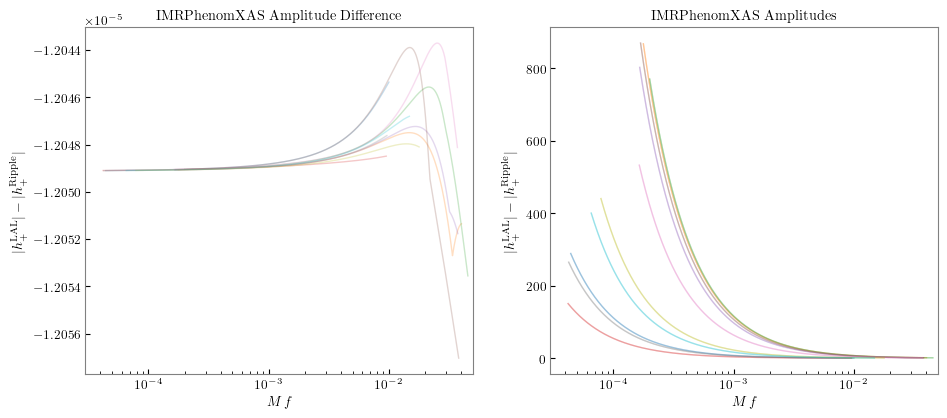

In [84]:
spacing = 10
frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
f_mask = frequencies > 9
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
Mf = total_mass[:, None] * MTSUN_SI * frequencies
XAS_Amp_diff = jnp.abs(lal_XAS_hp) - jnp.abs(ripple_XAS_amp)
# XAS_diff = jnp.abs(lal_XAS_hpc[0]) - jnp.abs(ripple_XAS_hpc[0])

for idx, (Mtot, lal_amp, ripple_amp) in enumerate(
    zip(total_mass[::spacing], 
        jnp.abs(lal_XAS_hp)[::spacing],
          jnp.abs(ripple_XAS_amp)[::spacing])):
    ripple_amp *= 3.1707
    diff = lal_amp - ripple_amp
    non_zero = diff != 0
    mask = f_mask & non_zero
    Mf = Mtot * MTSUN_SI * frequencies[mask]
    ax = axes[0]
    ax.plot(Mf, diff[mask] / lal_amp[mask], alpha=0.25, c=f'C{idx}')
    ax.set_ylabel(r'$|h_+^{\rm LAL}| - |h_+^{\rm Ripple}|$')
    ax.set_title('IMRPhenomXAS Amplitude Difference')
    ax = axes[1]
    ax.plot(Mf, lal_amp[mask], alpha=0.25, c=f'C{idx}')
    ax.plot(Mf, ripple_amp[mask], alpha=0.25, c=f'C{idx}')
    ax.set_ylabel(r'$|h_+^{\rm LAL}| - |h_+^{\rm Ripple}|$')
    ax.set_title('IMRPhenomXAS Amplitudes')



for ax in axes:
    ax.set_xscale('log')
    # ax.set_yscale('symlog', linthresh=1e-9)
    ax.set_xlabel(r'$M\,f$')
    ax.set_xlim(3e-5, 5e-2)

In [79]:
jnp.max(ripple_XAS_amp.imag, axis=-1) * np.pi

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float64)

In [80]:
1/3.1707

0.315387769262308

In [ ]:


amps = []


fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
Mf = total_mass[:, None] * MTSUN_SI * frequencies

ax = axes[0]
ax.set_title('IMRPhenomXAS_NRTidalv3')
for Mtot, diff in zip(total_mass[::spacing], NRTidal_diff[::spacing]):
    non_zero = diff != 0
    mask = f_mask & non_zero
    Mf = Mtot * MTSUN_SI * frequencies[mask]
    ax.plot(Mf, diff[mask], alpha=0.25)
    ax.set_ylabel(r'$|h_+^{\rm LAL}| - |h_+^{\rm Ripple}|$')